In [45]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [48]:
model = Classifier()

images, labels = next(iter(testloader))

# Get the class probabilities
ps = torch.exp(model(images))

# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


**topk()** will list teh top k values from a tensor.

Returns the k largest elements of the given input tensor along a given dimension.

In [49]:
x = torch.arange(1, 6)
print(x)
print(torch.topk(x, 3))

tensor([1, 2, 3, 4, 5])
torch.return_types.topk(
values=tensor([5, 4, 3]),
indices=tensor([4, 3, 2]))


In [50]:
top_prob, top_classes = ps.topk(1, dim=1)

print(top_classes[:10,:])

tensor([[0],
        [0],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2]])


In [31]:
target = labels.view(labels.shape[0], -1)
predictions = top_classes

print(target.shape)
print(predictions.shape)

# 1 - correct classification, 0 - misclassification
equals = target == predictions
print(equals[:10, :])
equals

isequal = top_classes == labels.view(*top_classes.shape)
print(isequal[:10, :])

print(isequal.type())

torch.Size([64, 1])
torch.Size([64, 1])
tensor([[False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False]])
tensor([[False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [False]])
torch.BoolTensor


Here, == gives bool result when executed locally and gives uint8 result when executed in teh workspace
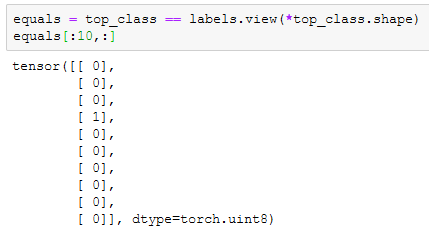

### type()
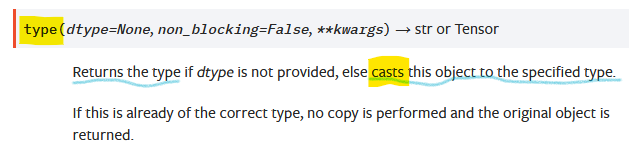

In [51]:
# check the tenspr type
print(equals.type())

# If equals is not float type, cast it to float
equalsFl = equals.type(torch.FloatTensor)
print(equalsFl.type())

torch.BoolTensor
torch.FloatTensor


In [52]:
#Accuracy 
accuracy = torch.mean(equalsFl)
print(f'Accuracy : {accuracy*100} %')

Accuracy : 17.1875 %


### Implement validation loop 

In [57]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 1
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## TODO: Implement the validation pass and print out the validation accuracy
        accuracy = 0
        test_loss = 0
        
        # Loop over test data and compute the validation accuracy
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        

Epoch: 1/1..  Training Loss: 0.516..  Test Loss: 0.448..  Test Accuracy: 0.834
